In [156]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import butter
from scipy import signal
from fooof.sim import gen_group_power_spectra, gen_power_spectrum

## Model Testing ##

 ### To create a Power Spectrum Density with known parameters:
 #### Helper Functions:
 1. generate_aperiodic

In [193]:
def generate_aperiodic(amp=1, expo=0.5, offset=0.1, noise_amp=0.05, f_range=[1,100], steps=1):

    frequencies = np.arange(f_range[0], f_range[1], steps)
    aperiodic_background = amp / (frequencies ** expo) + offset

    # Add noise that scales with log of frequency (in reverse, more noise at low frequencies)
    if noise_amp is not None:
        log_frequencies = np.log(frequencies)  # Take log of frequencies for scaling
        noise_std = noise_amp / log_frequencies  # Scale noise by the inverse log of frequencies
        noise = np.random.normal(scale=noise_std, size=frequencies.shape)  # Generate noise
        aperiodic_background += noise  # Add noise to the aperiodic background

    return frequencies, aperiodic_background

def gaussian_curve(mean=0, std=1, frequencies=None, scale=1):

    if frequencies is None:
        frequencies = np.arange(1, 100, 1)

    # Gaussian peak in frequency space
    peak = np.exp(-0.5 * ((np.log(frequencies) - np.log(mean)) / std) ** 2) * scale
    return peak

def generate_psd_with_gaussian_peak(amp=200, expo=0.05, offset=0.5, 
                                    peak_params=[[4,0.1]], noise_amp=2, 
                                    scale=10, f_range=[1, 150], steps=1):
    # Generate the aperiodic background in linear space
    frequencies, aperiodic_background = generate_aperiodic(amp, expo, offset, noise_amp, f_range=f_range, steps=steps)

    # Generate the Gaussian peak
    for i in peak_params:
        gaussian_peak = gaussian_curve(mean=i[0], std=i[1], frequencies=frequencies, scale=scale)
        aperiodic_background += gaussian_peak

    # Return the log-spaced frequencies for proper plotting
    return frequencies, aperiodic_background

def gen_params():
    num_peaks = random.randint(1,2)
    periodic_params = []
    peak_freq = [[3,5],[6,8]]
    for peak in range(num_peaks):
        periodic_param = [random.randint(peak_freq[peak][0],peak_freq[peak][1]), round(random.uniform(0.05,0.2),3)]
        periodic_params.append(periodic_param)
    return periodic_params

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def get_power_spec(epoch, lowcut, highcut, sampling_frequency, nperseg, method='psd'):
    # Apply Butterworth bandpass filter
    b, a = butter_bandpass(lowcut, highcut, sampling_frequency)
    filt_epoch = signal.filtfilt(b, a, epoch)

    if method == 'welch':
        # Compute power spectrum using Welch's method
        freq, power_spec = signal.welch(filt_epoch, fs=sampling_frequency, nperseg=1000)
    elif method == 'fft':
        fft_result = np.fft.fft(filt_epoch)
        n = len(filt_epoch)  # Number of sample points
        power_spec = np.abs(fft_result) ** 2 / (n * sampling_frequency)  # Normalize by number of points
        power_spec = power_spec[:n // 2]
        freq = np.fft.fftfreq(n, 1/sampling_frequency)[:n // 2]
    else:
        raise ValueError("Invalid method. Choose 'welch' or 'fft'.")

    return freq, power_spec

1


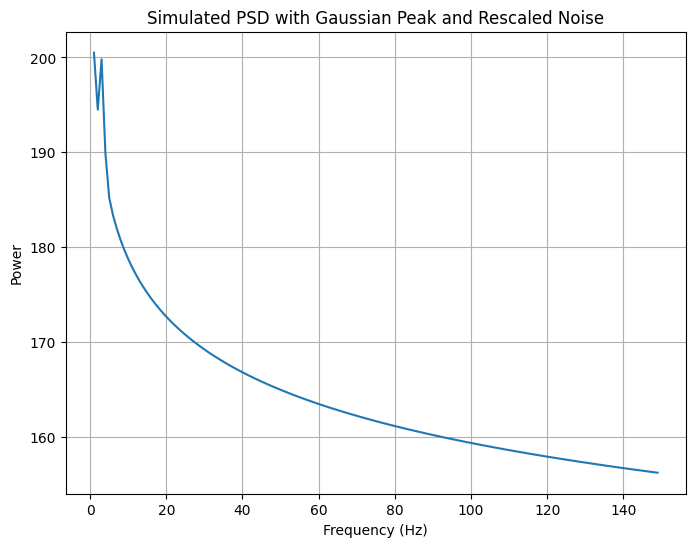

In [190]:
# Example plot
params = gen_params()
print(len(params))
frequencies, psd = generate_psd_with_gaussian_peak(amp=200, expo=0.05, offset=0.5, 
                                    peak_params=params, noise_amp=None, 
                                    scale=10, f_range=[1, 150], steps=1)

# Plotting the simulated PSD
plt.figure(figsize=(8, 6))
# plt.plot(frequencies[:12], psd[:12])
plt.plot(frequencies, psd)

plt.title("Simulated PSD with Gaussian Peak and Rescaled Noise")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid(True)

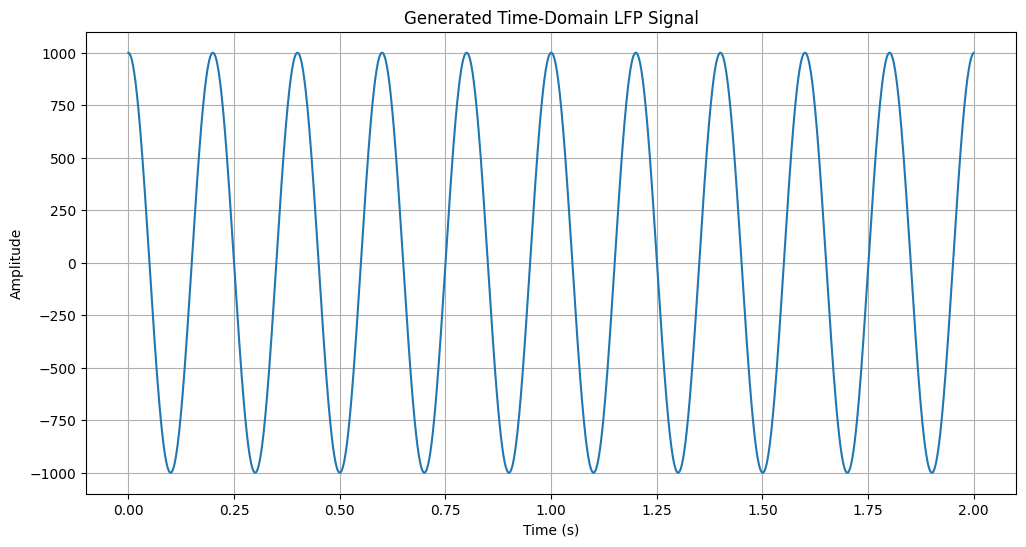

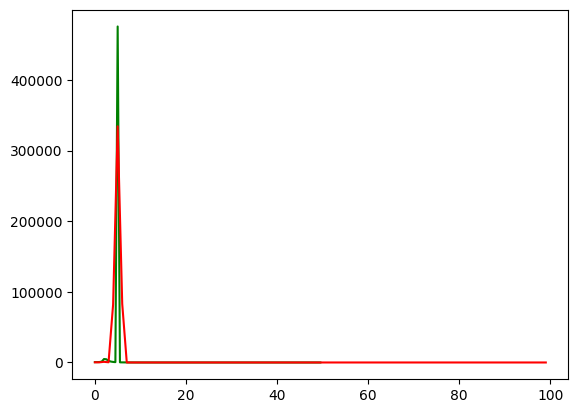

In [197]:
import numpy as np
import matplotlib.pyplot as plt

def test_psd2time(psd,fs,duration):
    n = int(fs * duration)
    ps = psd * n * fs

def psd_to_time_domain(psd, freqs, fs, duration):
    """
    Convert a PSD to a time-domain LFP signal.
    
    Parameters:
    - psd: Power Spectral Density (array-like)
    - fs: Sampling frequency (in Hz)
    - duration: Duration of the signal (in seconds)

    Returns:
    - time_domain_signal: Time-domain LFP signal
    - t: Time vector
    """
    n = int(fs * duration)
    ps = psd * n * fs

    # Compute the magnitude spectrum from the PSD
    magnitude_spectrum = np.sqrt(ps)

    # Generate random phases
    random_phases = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(freqs)))

    # Combine magnitude and phase to form the frequency-domain signal
    freq_domain_signal = magnitude_spectrum

    if np.any(np.isinf(freq_domain_signal)) or np.any(np.isnan(freq_domain_signal)):
        print("Frequency-Domain Signal contains NaN or Inf values:", freq_domain_signal)

    time_domain_signal = np.fft.irfft(ps, n=n)

    # Check for any infinite or NaN values in time_domain_signal
    if np.any(np.isinf(time_domain_signal)) or np.any(np.isnan(time_domain_signal)):
        print("Time-Domain Signal contains NaN or Inf values:", time_domain_signal)

    # Create time vector
    t = np.linspace(0, duration, n)

    return time_domain_signal, t

# Example PSD and parameters
fs = 1000  # Sampling frequency (Hz)
duration = 2  # Duration of the signal (seconds)

# Generate the time-domain LFP signal
time_domain_signal, t = psd_to_time_domain(psd[0:], frequencies, fs, duration)

# Plot the result
plt.figure(figsize=(12, 6))
plt.plot(t, time_domain_signal)
plt.title('Generated Time-Domain LFP Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

for method in ['fft','welch']:
    freq, power_spec = get_power_spec(time_domain_signal, 2, 150, 1000, 1000, method)
    if method == 'fft':
        plt.plot(freq[:100], power_spec[:100],color='g', label='FFT')
    elif method == 'welch':
        plt.plot(freq[:100], power_spec[:100], color='r', label='Welch')



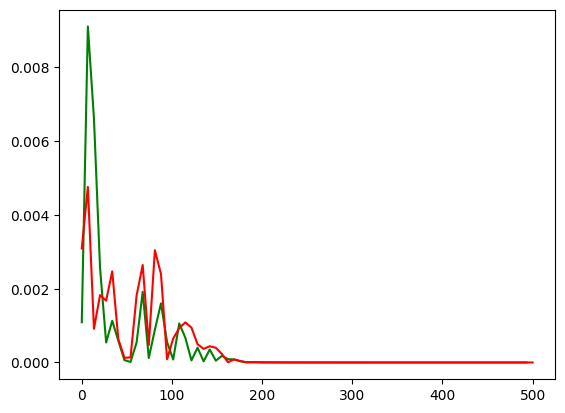

In [168]:
def psd_to_time_domain(psd):
    # Step 1: Compute the magnitude spectrum from the PSD
    magnitude_spectrum = np.sqrt(psd)

    # Step 2: Generate random phases between 0 and 2pi
    random_phases = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(psd)))

    # Step 3: Combine magnitude and phase to form the frequency-domain signal
    freq_domain_signal = magnitude_spectrum * random_phases

    # Step 4: Use inverse FFT to convert back to the time domain
    time_domain_signal = np.fft.ifft(freq_domain_signal)

    # Return the real part of the inverse FFT (since the time-domain signal is real)
    return np.real(time_domain_signal)

lfp_data = psd_to_time_domain(psd[1:])


# plt.plot(frequencies,psd, color='b', label="original psd")

for method in ['fft','welch']:
    freq, power_spec = get_power_spec(lfp_data, 2, 150, 1000, 1000, method)
    if method == 'fft':
        plt.plot(freq, power_spec,color='g', label='FFT')
    elif method == 'welch':
        plt.plot(freq, power_spec, color='r', label='Welch')




#### Creating FOOOF Groups for testing

##### Using Gen_power_spectrum from the FOOOF Library

In [110]:
def gen_params():
    num_peaks = random.randint(1,2)
    periodic_params = []
    peak_freq = [[2,5],[5,8]]
    for peak in range(num_peaks):
        periodic_param = [random.randint(peak_freq[peak][0],peak_freq[peak][1]), round(random.uniform(0.008,0.012),3), round(random.uniform(0.3,2),3)]
        periodic_params.append(periodic_param)
    return periodic_params

2


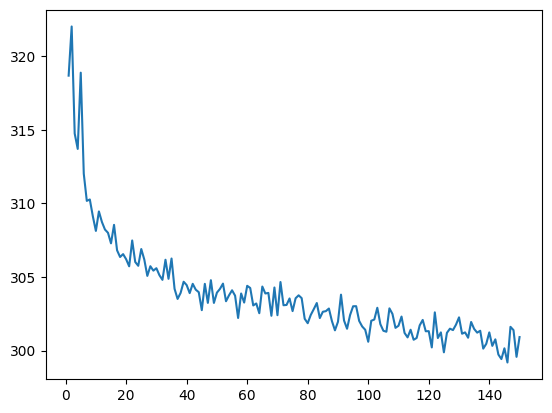

In [117]:
params = gen_params()
test = gen_power_spectrum(freq_range=[0,150], aperiodic_params=[2.5, 0.01], periodic_params=params, nlv=0.001, freq_res=1, return_params=False)
# plt.plot(test[0][1:12], test[1][1:12])
print(len(params))
plt.plot(test[0], test[1])

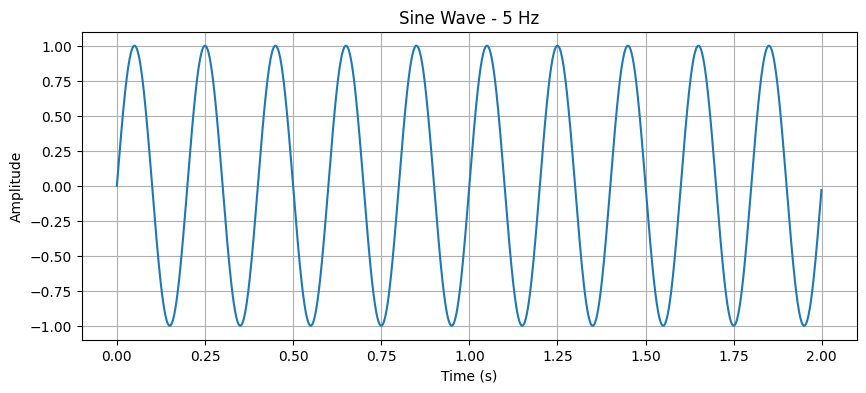

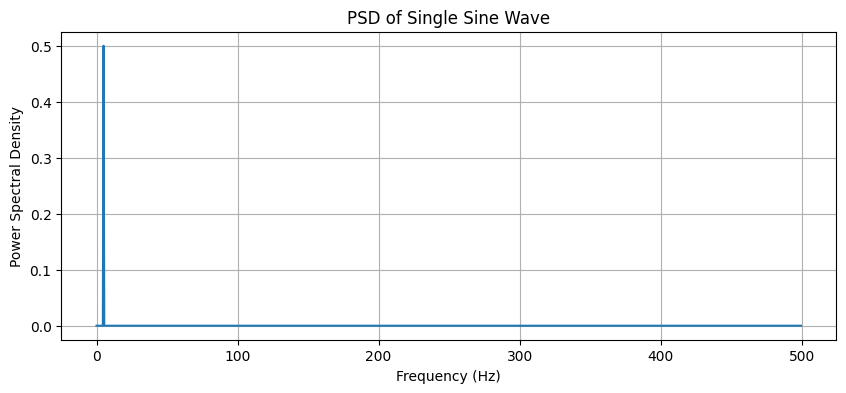

In [196]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to generate a sine wave signal
def generate_sine_wave(frequency, amplitude, duration, fs):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t)
    return sine_wave, t

# Sampling frequency and duration
fs = 1000  # Sampling frequency (Hz)
duration = 2  # Duration in seconds

# Generate a single sine wave (e.g., 5 Hz)
frequency = 5  # Frequency of the sine wave (Hz)
amplitude = 1  # Amplitude of the sine wave
sine_wave, t = generate_sine_wave(frequency, amplitude, duration, fs)

# Plot the sine wave
plt.figure(figsize=(10, 4))
plt.plot(t, sine_wave)
plt.title(f"Sine Wave - {frequency} Hz")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


def compute_psd(signal, fs):
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, 1/fs)[:n//2]  # Frequency bins
    psd = (np.abs(fft_result[:n//2])**2) / (n * fs)  # Normalized PSD
    return freq, psd

# Compute PSD of the sine wave
freq, psd = compute_psd(sine_wave, fs)

# Plot the PSD
plt.figure(figsize=(10, 4))
plt.plot(freq, psd)
plt.title("PSD of Single Sine Wave")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.grid(True)
plt.show()


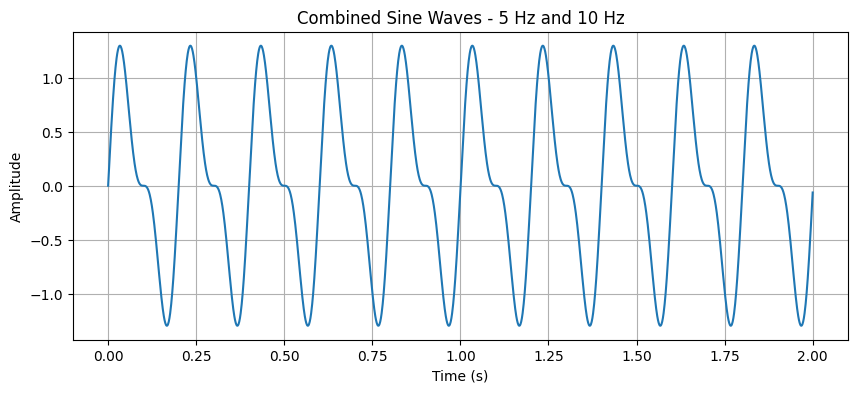

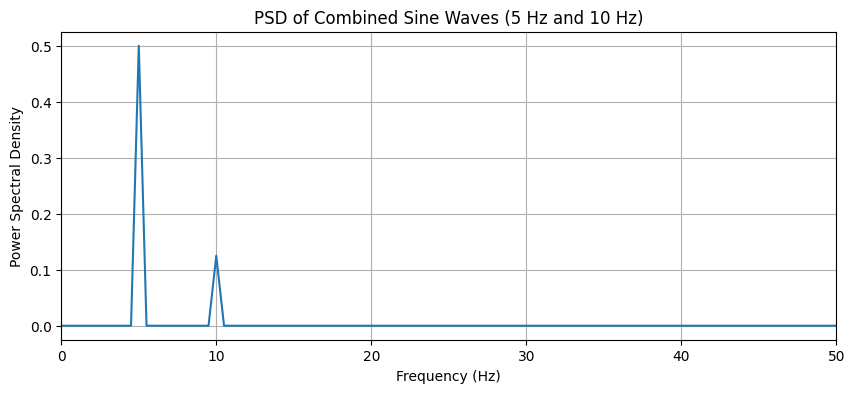

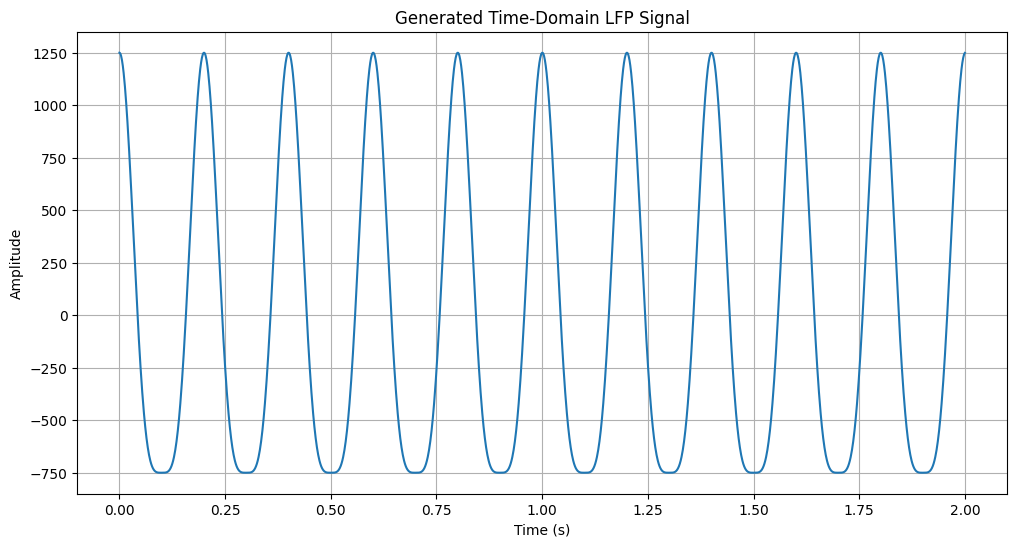

(0.0, 50.0)

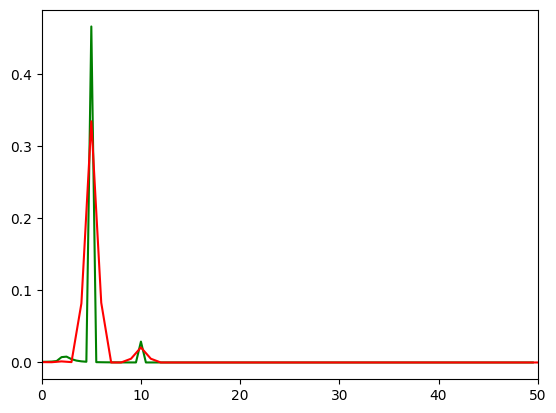

In [205]:
# Generate another sine wave (e.g., 10 Hz)
frequency2 = 10  # Second sine wave frequency (Hz)
amplitude2 = 0.5  # Amplitude of the second sine wave
sine_wave2, _ = generate_sine_wave(frequency2, amplitude2, duration, fs)

# Combine the two sine waves
combined_signal = sine_wave + sine_wave2

# Plot the combined signal
plt.figure(figsize=(10, 4))
plt.plot(t, combined_signal)
plt.title("Combined Sine Waves - 5 Hz and 10 Hz")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Compute and plot PSD of the combined signal
freq, psd = compute_psd(combined_signal, fs)
plt.figure(figsize=(10, 4))
plt.plot(freq, psd)
plt.title("PSD of Combined Sine Waves (5 Hz and 10 Hz)")
plt.xlabel("Frequency (Hz)")
plt.xlim(0,50)
plt.ylabel("Power Spectral Density")
plt.grid(True)
plt.show()

# Example PSD and parameters
fs = 1000  # Sampling frequency (Hz)
duration = 2  # Duration of the signal (seconds)

# Generate the time-domain LFP signal
time_domain_signal, t = psd_to_time_domain(psd[0:], freq, fs, duration)

# Plot the result
plt.figure(figsize=(12, 6))
plt.plot(t, time_domain_signal)
plt.title('Generated Time-Domain LFP Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

for method in ['fft','welch']:
    freq, power_spec = get_power_spec(time_domain_signal, 2, 150, 1000, 1000, method)
    power_spec = power_spec / (fs*fs)
    if method == 'fft':
        plt.plot(freq[:100], power_spec[:100],color='g', label='FFT')
    elif method == 'welch':
        plt.plot(freq[:100], power_spec[:100], color='r', label='Welch')
plt.xlim(0,50)

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Sample data
np.random.seed(0)
data = pd.DataFrame({
    'category': np.random.choice(['A', 'B', 'C'], size=100),
    'value': np.random.randn(100)
})

# Create a main figure
fig, ax = plt.subplots(figsize=(8, 6))

# Main plot (e.g., a boxplot)
sns.boxplot(x='category', y='value', data=data, ax=ax)
ax.set_title('Main Plot')

# Create an inset for the strip plot
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper right')

# Strip plot in the inset
sns.stripplot(x='category', y='value', data=data, ax=inset_ax, color='red', jitter=True)
inset_ax.set_title('Strip Plot')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()



/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_88224/2748257134.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 800x600 with 2 Axes>